In [ ]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pydicom
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.initializers import Constant
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.python.ops import array_ops
from tqdm import tqdm
from keras import backend as K
import tensorflow as tf
import keras
from keras.applications import Xception
from keras.models import Model, load_model
from math import ceil, floor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import log_loss
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [ ]:
os.listdir('/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection')

['stage_2_train',
 'stage_2_test',
 'stage_2_sample_submission.csv',
 'stage_2_train.csv']

In [ ]:
BASE_PATH = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = 'stage_2_train/'
TEST_DIR = 'stage_2_test/'
train_df = pd.read_csv(BASE_PATH + 'stage_2_train.csv')

In [ ]:
sub_df = pd.read_csv(BASE_PATH + 'stage_2_sample_submission.csv')

train_df['filename'] = train_df['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
train_df['type'] = train_df['ID'].apply(lambda st: st.split('_')[2])
sub_df['filename'] = sub_df['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
sub_df['type'] = sub_df['ID'].apply(lambda st: st.split('_')[2])

print(train_df.shape)
train_df.head()

(4516842, 4)


,ID,Label,filename,type
0,ID_12cadc6af_epidural,0,ID_12cadc6af.png,epidural
1,ID_12cadc6af_intraparenchymal,0,ID_12cadc6af.png,intraparenchymal
2,ID_12cadc6af_intraventricular,0,ID_12cadc6af.png,intraventricular
3,ID_12cadc6af_subarachnoid,0,ID_12cadc6af.png,subarachnoid
4,ID_12cadc6af_subdural,0,ID_12cadc6af.png,subdural


In [ ]:
test_df = pd.DataFrame(sub_df.filename.unique(), columns=['filename'])
print(test_df.shape)
test_df.head()

(121232, 1)


,filename
0,ID_0fbf6a978.png
1,ID_d62ec3412.png
2,ID_cb544194b.png
3,ID_0d62513ec.png
4,ID_fc45b2151.png


In [ ]:
subtypes = train_df.groupby('type').sum()
subtypes

,Label
type,
any,107933
epidural,3145
intraparenchymal,36118
intraventricular,26205
subarachnoid,35675
subdural,47166


<AxesSubplot:xlabel='Label', ylabel='type'>

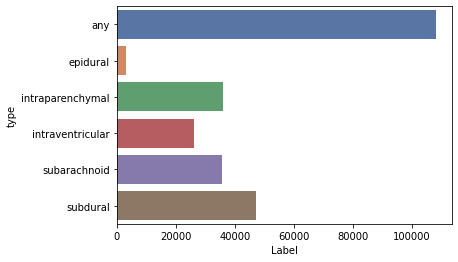

In [ ]:
sns.barplot(y=subtypes.index, x=subtypes.Label, palette="deep")

**From this we can note a few things: **
* There are 107933 images with "any" hemmorhages. This is quite low compared to the 720000 images we have in the dataset 
* Thus, we could create a generator with all the images containing hemorrages and the same amount of images not subject to an hemmorhage. 
* Additionaly, all types of hemmorhages are realtively equaly represented, except the 'epidural' type that has only 3145 cases in the whole dataset. We could try to run in with this type discarded.  

In [ ]:
np.random.seed(2019)
sample_files = np.random.choice(os.listdir(BASE_PATH + TRAIN_DIR), 400000) # take the rest for testing
sample_df = train_df[train_df.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_files)]

In [ ]:
pivot_df = sample_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(pivot_df.shape)
pivot_df

(310498, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_00005679d.png,0,0,0,0,0,0
1,ID_00008ce3c.png,0,0,0,0,0,0
2,ID_0000f1657.png,0,0,0,0,0,0
3,ID_0001f7f62.png,0,0,0,0,0,0
4,ID_0002108bd.png,0,0,0,0,0,0
...,...,...,...,...,...,...,...
310493,ID_ffff5a8be.png,0,0,0,0,0,0
310494,ID_ffff639f4.png,0,0,0,0,0,0
310495,ID_ffff80705.png,0,0,0,0,0,0
310496,ID_ffff82e46.png,0,0,0,0,0,0


In [ ]:
test_df = sub_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(test_df.shape)
test_df

(121232, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000000e27.png,0.5,0.5,0.5,0.5,0.5,0.5
1,ID_000009146.png,0.5,0.5,0.5,0.5,0.5,0.5
2,ID_00007b8cb.png,0.5,0.5,0.5,0.5,0.5,0.5
3,ID_000134952.png,0.5,0.5,0.5,0.5,0.5,0.5
4,ID_000176f2a.png,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
121227,ID_fffb40805.png,0.5,0.5,0.5,0.5,0.5,0.5
121228,ID_fffc74999.png,0.5,0.5,0.5,0.5,0.5,0.5
121229,ID_fffd3cc3b.png,0.5,0.5,0.5,0.5,0.5,0.5
121230,ID_fffdcca96.png,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
np.random.seed(2019)
sample_test = np.random.choice(os.listdir(BASE_PATH + TEST_DIR), 20000) 
test_sample_df = test_df[test_df.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_test)]


In [ ]:
test_sample_df

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
5,ID_0001af484.png,0.5,0.5,0.5,0.5,0.5,0.5
12,ID_00060ace2.png,0.5,0.5,0.5,0.5,0.5,0.5
16,ID_000a50137.png,0.5,0.5,0.5,0.5,0.5,0.5
24,ID_000cfc3de.png,0.5,0.5,0.5,0.5,0.5,0.5
29,ID_000fa581b.png,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
121202,ID_fff33fd4d.png,0.5,0.5,0.5,0.5,0.5,0.5
121212,ID_fff6fc13f.png,0.5,0.5,0.5,0.5,0.5,0.5
121213,ID_fff6ff09c.png,0.5,0.5,0.5,0.5,0.5,0.5
121226,ID_fffaf0843.png,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
validation_df = pivot_df.sample(int(len(pivot_df) * 0.15))  
validation_df 

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
44011,ID_2445df98e.png,0,0,0,0,0,0
89151,ID_49ad1664d.png,0,0,0,0,0,0
97132,ID_50324cad1.png,0,0,0,0,0,0
264699,ID_da39c7ec3.png,0,0,0,0,0,0
95553,ID_4eef12b53.png,0,0,0,0,0,0
...,...,...,...,...,...,...,...
74854,ID_3dcbfeab0.png,0,0,0,0,0,0
39978,ID_20ecfc869.png,0,0,0,0,0,0
124373,ID_66736ee88.png,0,0,0,0,0,0
137189,ID_711e2ca9d.png,0,0,0,0,0,0


In [ ]:
y_true = []
for i in range(len(validation_df)): 
    y_true.append(validation_df.iloc[i,1])
        


In [ ]:
len(y_true)

46574

In [ ]:
full_true = []
for i in range(len(validation_df)): 
    for j in range(1,7): 
        full_true.append(validation_df.iloc[i,j])
        


In [ ]:
#len(full_true)

In [ ]:
training_df = pivot_df[~(pivot_df.filename.isin(validation_df.filename))]
training_df


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_00005679d.png,0,0,0,0,0,0
2,ID_0000f1657.png,0,0,0,0,0,0
3,ID_0001f7f62.png,0,0,0,0,0,0
4,ID_0002108bd.png,0,0,0,0,0,0
5,ID_000229f2a.png,0,0,0,0,0,0
...,...,...,...,...,...,...,...
310493,ID_ffff5a8be.png,0,0,0,0,0,0
310494,ID_ffff639f4.png,0,0,0,0,0,0
310495,ID_ffff80705.png,0,0,0,0,0,0
310496,ID_ffff82e46.png,0,0,0,0,0,0


In [ ]:
print(training_df.head())
print(validation_df.head())


type          filename  any  epidural  intraparenchymal  intraventricular  \
0     ID_00005679d.png    0         0                 0                 0   
2     ID_0000f1657.png    0         0                 0                 0   
3     ID_0001f7f62.png    0         0                 0                 0   
4     ID_0002108bd.png    0         0                 0                 0   
5     ID_000229f2a.png    0         0                 0                 0   

type  subarachnoid  subdural  
0                0         0  
2                0         0  
3                0         0  
4                0         0  
5                0         0  
type            filename  any  epidural  intraparenchymal  intraventricular  \
44011   ID_2445df98e.png    0         0                 0                 0   
89151   ID_49ad1664d.png    0         0                 0                 0   
97132   ID_50324cad1.png    0         0                 0                 0   
264699  ID_da39c7ec3.png    0      

In [ ]:
def get_pixels_hu(scan): 
    image = np.stack([scan.pixel_array])
    image = image.astype(np.int16) 
    
    image[image == -2000] = 0
    
    intercept = scan.RescaleIntercept
    slope = scan.RescaleSlope
    
    if slope != 1: 
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
    
    image += np.int16(intercept) 
    
    return np.array(image, dtype=np.int16)

In [ ]:
def apply_window(image, center, width):
    image = image.copy()
    min_value = center - width // 2
    max_value = center + width // 2
    image[image < min_value] = min_value
    image[image > max_value] = max_value
    return image


def apply_window_policy(image):

    image1 = apply_window(image, 40, 80) # brain
    image2 = apply_window(image, 80, 200) # subdural
    image3 = apply_window(image, 40, 380) # bone
    image1 = (image1 - 0) / 80
    image2 = (image2 - (-20)) / 200
    image3 = (image3 - (-150)) / 380
    image = np.array([
        image1 - image1.mean(),
        image2 - image2.mean(),
        image3 - image3.mean(),
    ]).transpose(1,2,0)

    return image
#maybe try a new function 

In [ ]:
def save_and_resize(filenames, load_dir):    
    save_dir = '/kaggle/tmp/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for filename in tqdm(filenames):
        try:
            path = load_dir + filename
            new_path = save_dir + filename.replace('.dcm', '.png')
            dcm = pydicom.dcmread(path)
            image = get_pixels_hu(dcm)
            image = apply_window_policy(image[0])
            image -= image.min((0,1))
            image = (255*image).astype(np.uint8)
            image = cv2.resize(image, (299, 299)) #smaller
            res = cv2.imwrite(new_path, image)
            
        except ValueError:
            continue # it returns a black image, super weird 

In [ ]:
save_and_resize(filenames=sample_files, load_dir=BASE_PATH + TRAIN_DIR)
save_and_resize(filenames=sample_test, load_dir=BASE_PATH + TEST_DIR)

100%|██████████| 20000/20000 [07:47<00:00, 42.75it/s]


In [ ]:
def create_model():    
    base_model = Xception(weights = 'imagenet', include_top = False, input_shape = (299,299,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.15)(x)
    y_pred = Dense(6, activation = 'sigmoid')(x)

    return Model(inputs = base_model.input, outputs = y_pred)

In [ ]:
LR = 0.00005
model = create_model()

83689472/83683744 [==============================] - 2s 0us/step


In [ ]:
model.compile(optimizer = Adam(learning_rate = LR), 
              loss = 'binary_crossentropy', # <- requires balance/ Binary for unbalanced
              metrics = [tf.keras.metrics.AUC()]) #run both 

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
BATCH_SIZE = 16 # had to revert back to 16 to have a comparaison point with the large model I ran locally 

def create_datagen():
    return ImageDataGenerator()

def create_test_gen():
    return ImageDataGenerator().flow_from_dataframe(
        test_sample_df,
        directory=  '/kaggle/tmp/',
        x_col='filename',
        class_mode=None,
        target_size=(299, 299),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

def create_train_gen(datagen):
    return datagen.flow_from_dataframe(
        training_df, 
        directory='/kaggle/tmp/',
        
        x_col='filename', 
        y_col=['any', 'epidural', 'intraparenchymal', 
               'intraventricular', 'subarachnoid', 'subdural'],
        class_mode='raw',
        target_size=(299, 299),
        batch_size=BATCH_SIZE,
        
       
    )
def create_val_gen(datagen): 
    return datagen.flow_from_dataframe(
        validation_df, 
        directory='/kaggle/tmp/',
        
        x_col='filename', 
        y_col=['any', 'epidural', 'intraparenchymal', 
               'intraventricular', 'subarachnoid', 'subdural'],
        class_mode='raw',
        target_size=(299, 299),
        batch_size=BATCH_SIZE,
        shuffle=False,
        
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_train_gen(data_generator)
val_gen = create_val_gen(data_generator)
test_gen = create_test_gen()

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 263923 validated image filenames.
Found 46574 validated image filenames.
Found 18509 validated image filenames.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
checkpoint = ModelCheckpoint(
    'effnetb4.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)
Early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, 
                                              mode='auto', baseline=None, restore_best_weights=False)
#train_length = len(train_df)
total_steps = sample_files.shape[0] // BATCH_SIZE
total_steps = total_steps // 4
history = model.fit_generator(
    train_gen,
    steps_per_epoch = total_steps,
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    callbacks=[checkpoint, Early_stop],
    epochs=10
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
6250/6250 [==============================] - 2505s 399ms/step - loss: 0.1377 - auc: 0.9118 - val_loss: 0.0829 - val_auc: 0.9685
Epoch 2/10
6250/6250 [==============================] - 2491s 399ms/step - loss: 0.0819 - auc: 0.9684 - val_loss: 0.0761 - val_auc: 0.9722
Epoch 3/10
6250/6250 [==============================] - 2491s 399ms/step - loss: 0.0716 - auc: 0.9755 - val_loss: 0.0739 - val_auc: 0.9724
Epoch 4/10
6250/6250 [==============================] - 2493s 399ms/step - loss: 0.0621 - auc: 0.9816 - val_loss: 0.0711 - val_auc: 0.9732
Epoch 5/10
6250/6250 [==============================] - 2493s 399ms/step - loss: 0.0559 - auc: 0.9849 - val_loss: 0.0702 - val_auc: 0.9737
Epoch 6/10
6250/6250 [==============================] - 2493s 399ms/step - loss: 0.0485 - auc: 0.9876 - val_loss: 0.0724 - val_auc: 0.9701
Epoch 00006: early stopping


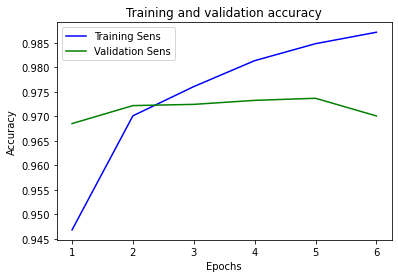

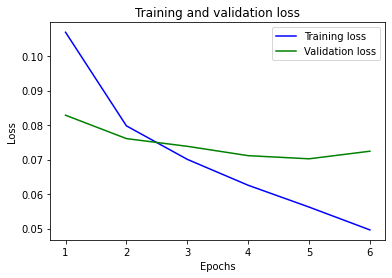

In [ ]:
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training Sens')
plt.plot(epochs, val_acc, 'g', label='Validation Sens')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

Idea here: make pred on validation, then for each image load the image, the prediciton, and the labels in validation_df 

In [ ]:
val_preds = model.predict_generator(val_gen, verbose = 1)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2911/2911 [==============================] - 240s 82ms/step


In [ ]:
val_preds

array([[4.88043157e-03, 6.79597770e-06, 2.59264798e-05, 4.68799080e-05,
        7.67226156e-04, 1.14669406e-03],
       [7.18922215e-03, 7.54026478e-05, 1.03923574e-03, 5.62073692e-05,
        2.22415710e-03, 2.99905590e-03],
       [1.50264823e-03, 1.69125087e-05, 2.14794316e-04, 2.45318486e-04,
        5.09307953e-04, 4.39669151e-04],
       ...,
       [7.44163350e-04, 5.20676076e-06, 1.44943202e-04, 1.26621308e-04,
        1.54648151e-04, 6.10105984e-04],
       [6.86777104e-03, 3.21044819e-04, 8.39803484e-04, 3.31978255e-04,
        1.91761239e-03, 2.16134475e-03],
       [5.52858226e-04, 1.05234585e-05, 1.65788824e-05, 2.96299459e-06,
        4.11572946e-05, 6.01386942e-04]], dtype=float32)

In [ ]:
y_preds = []
for i in range(len(val_preds)):
    y_preds.append(0)
    for value in val_preds[i]: 
        if value > 0.5: 
            y_preds[i] = 1
            break
            
        
len(y_preds)


46574

In [ ]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_preds)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

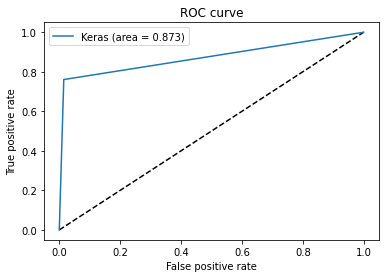

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
print('2*2 Confusion Matrix')
print(confusion_matrix(y_true, y_preds))
cm = confusion_matrix(y_true, y_preds)

2*2 Confusion Matrix
[[39426   590]
 [ 1569  4989]]


In [ ]:
import itertools   
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_labels = ['no hemorrhage', 'has hemorrhage']

Confusion matrix, without normalization
[[39426   590]
 [ 1569  4989]]


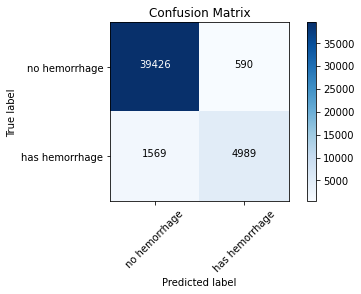

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix')

In [ ]:
predictions_list = []
for pred in val_preds: 
    predictions_list.append(pred)

len(predictions_list)

46574

In [ ]:
validation_frame = validation_df.drop(['filename'], axis=1)
validation_frame 

type,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
44011,0,0,0,0,0,0
89151,0,0,0,0,0,0
97132,0,0,0,0,0,0
264699,0,0,0,0,0,0
95553,0,0,0,0,0,0
...,...,...,...,...,...,...
74854,0,0,0,0,0,0
39978,0,0,0,0,0,0
124373,0,0,0,0,0,0
137189,0,0,0,0,0,0


In [ ]:
len(validation_frame) 

46574

In [ ]:
if len(predictions_list) == len(validation_frame): 
    validation_frame.iloc[:,:] = predictions_list
else: 
    print("fix this issue")
        

In [ ]:
validation_frame.insert(0, "filename", validation_df.filename)
validation_frame.insert(7, "true_any" ,validation_df.iloc[:,1])
validation_frame.insert(8, "true_epidural", validation_df.epidural)
validation_frame.insert(9, "true_intraparenchymal", validation_df.intraparenchymal)
validation_frame.insert(10, "true_intraventricular", validation_df.intraventricular)
validation_frame.insert(11, "true_subarachnoid", validation_df.subarachnoid)
validation_frame.insert(12, "true_subdural", validation_df.subdural)

In [ ]:
validation_frame

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,true_any,true_epidural,true_intraparenchymal,true_intraventricular,true_subarachnoid,true_subdural
44011,ID_2445df98e.png,0.004880,0.000007,0.000026,0.000047,0.000767,0.001147,0,0,0,0,0,0
89151,ID_49ad1664d.png,0.007189,0.000075,0.001039,0.000056,0.002224,0.002999,0,0,0,0,0,0
97132,ID_50324cad1.png,0.001503,0.000017,0.000215,0.000245,0.000509,0.000440,0,0,0,0,0,0
264699,ID_da39c7ec3.png,0.530057,0.042820,0.018070,0.002069,0.011142,0.398806,0,0,0,0,0,0
95553,ID_4eef12b53.png,0.002420,0.000042,0.000306,0.000102,0.000403,0.001881,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74854,ID_3dcbfeab0.png,0.000217,0.000003,0.000009,0.000003,0.000080,0.000200,0,0,0,0,0,0
39978,ID_20ecfc869.png,0.000570,0.000008,0.000359,0.000197,0.000254,0.000067,0,0,0,0,0,0
124373,ID_66736ee88.png,0.000744,0.000005,0.000145,0.000127,0.000155,0.000610,0,0,0,0,0,0
137189,ID_711e2ca9d.png,0.006868,0.000321,0.000840,0.000332,0.001918,0.002161,0,0,0,0,0,0


In [ ]:
for i in range(100): 
    if validation_frame.iloc[i,1] > 0.8: 
        print("ID is : " + str(validation_frame.iloc[i,0]))
        for j in range(1,7): 
            print("predicition = " +  str(validation_frame.iloc[i,j]) )
        for k in range(7,13): 
            print("true predicition = " +  str(validation_frame.iloc[i,k]))
# activation map

ID is : ID_b021b9cc9.png
predicition = 0.8761910796165466
predicition = 0.00015714814071543515
predicition = 0.01156904362142086
predicition = 0.9051729440689087
predicition = 0.03242192417383194
predicition = 0.021564068272709846
true predicition = 1
true predicition = 0
true predicition = 0
true predicition = 1
true predicition = 0
true predicition = 0
ID is : ID_8d30b0f9a.png
predicition = 0.9951034784317017
predicition = 0.00015572525444440544
predicition = 0.005770446732640266
predicition = 0.04055109992623329
predicition = 0.9889285564422607
predicition = 0.014821131713688374
true predicition = 1
true predicition = 0
true predicition = 0
true predicition = 0
true predicition = 1
true predicition = 0
ID is : ID_2a7407616.png
predicition = 0.995261549949646
predicition = 0.00013436349399853498
predicition = 0.8919529914855957
predicition = 0.7582352161407471
predicition = 0.010991419665515423
predicition = 0.0023261650931090117
true predicition = 1
true predicition = 0
true predici

In [ ]:
any_preds = validation_frame['any']
max_index = any_preds.idxmax()
max_index

302402

In [ ]:
def img_to_heatmap(): 
    highest_predicted_img = validation_frame.loc[max_index,'filename']
    if validation_frame.loc[max_index, 'true_any'] == 1:
        return highest_predicted_img

In [ ]:
highest_predicted_img =  img_to_heatmap()
highest_predicted_img

'ID_f94f5d671.png'

In [ ]:
test_preds = model.predict_generator(test_gen, verbose = 1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1157/1157 [==============================] - 92s 79ms/step


In [ ]:
test_preds

array([[5.9629550e-05, 6.4686780e-08, 1.3667896e-05, 4.2344514e-06,
        3.6718945e-06, 1.2835955e-05],
       [9.9901529e-04, 7.4361010e-06, 1.2249072e-04, 5.0314728e-05,
        7.6918403e-04, 9.8209472e-05],
       [8.9907306e-01, 1.9440278e-03, 4.7485426e-01, 7.4687248e-01,
        2.7862379e-01, 3.3490080e-02],
       ...,
       [1.1457704e-03, 8.6561362e-05, 4.4787295e-05, 2.8918052e-07,
        2.6855094e-04, 3.6832181e-04],
       [6.9312606e-04, 5.3474596e-06, 1.4605244e-05, 7.9251040e-06,
        5.4236921e-04, 2.3878882e-04],
       [9.0481425e-03, 1.5301078e-04, 1.2078742e-03, 5.3350901e-04,
        2.2465526e-03, 5.4920763e-03]], dtype=float32)

In [ ]:
predictions_list_test = []
for pred in test_preds: 
    predictions_list_test.append(pred)



In [ ]:
test_frame =  test_sample_df.drop(['filename'], axis=1)
test_frame

type,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
5,0.5,0.5,0.5,0.5,0.5,0.5
12,0.5,0.5,0.5,0.5,0.5,0.5
16,0.5,0.5,0.5,0.5,0.5,0.5
24,0.5,0.5,0.5,0.5,0.5,0.5
29,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...
121202,0.5,0.5,0.5,0.5,0.5,0.5
121212,0.5,0.5,0.5,0.5,0.5,0.5
121213,0.5,0.5,0.5,0.5,0.5,0.5
121226,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
test_frame.iloc[:,:] = predictions_list_test
test_frame

type,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
5,0.000060,6.468678e-08,0.000014,4.234451e-06,0.000004,0.000013
12,0.000999,7.436101e-06,0.000122,5.031473e-05,0.000769,0.000098
16,0.899073,1.944028e-03,0.474854,7.468725e-01,0.278624,0.033490
24,0.000442,3.012911e-06,0.000172,1.535425e-04,0.000422,0.000027
29,0.016134,8.428097e-04,0.001005,4.806009e-04,0.003018,0.010064
...,...,...,...,...,...,...
121202,0.000384,2.584474e-06,0.000032,2.598462e-05,0.000084,0.000220
121212,0.984386,1.886656e-02,0.055900,4.621408e-04,0.074550,0.880309
121213,0.001146,8.656136e-05,0.000045,2.891805e-07,0.000269,0.000368
121226,0.000693,5.347460e-06,0.000015,7.925104e-06,0.000542,0.000239


In [ ]:
test_frame.insert(0, "filename", test_df.filename)
test_frame

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
5,ID_0001af484.png,0.000060,6.468678e-08,0.000014,4.234451e-06,0.000004,0.000013
12,ID_00060ace2.png,0.000999,7.436101e-06,0.000122,5.031473e-05,0.000769,0.000098
16,ID_000a50137.png,0.899073,1.944028e-03,0.474854,7.468725e-01,0.278624,0.033490
24,ID_000cfc3de.png,0.000442,3.012911e-06,0.000172,1.535425e-04,0.000422,0.000027
29,ID_000fa581b.png,0.016134,8.428097e-04,0.001005,4.806009e-04,0.003018,0.010064
...,...,...,...,...,...,...,...
121202,ID_fff33fd4d.png,0.000384,2.584474e-06,0.000032,2.598462e-05,0.000084,0.000220
121212,ID_fff6fc13f.png,0.984386,1.886656e-02,0.055900,4.621408e-04,0.074550,0.880309
121213,ID_fff6ff09c.png,0.001146,8.656136e-05,0.000045,2.891805e-07,0.000269,0.000368
121226,ID_fffaf0843.png,0.000693,5.347460e-06,0.000015,7.925104e-06,0.000542,0.000239


ID_000a50137.png has a probability: 0.89907306 for a 'any' type of hemorrhage


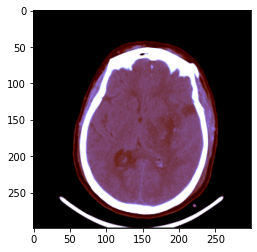

ID_00314064c.png has a probability: 0.97575504 for a 'any' type of hemorrhage


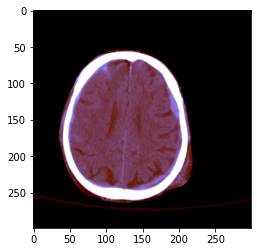

ID_00314064c.png has a probability: 0.84868056 for a 'subarachnoid' type of hemorrhage


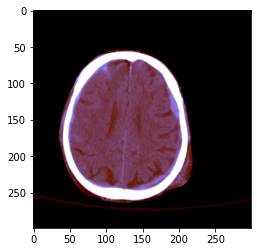

ID_00314064c.png has a probability: 0.86561227 for a 'subdural' type of hemorrhage


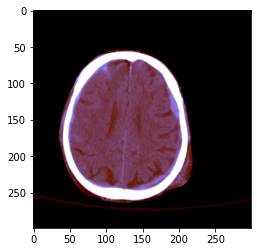

ID_0035af38a.png has a probability: 0.8091537 for a 'any' type of hemorrhage


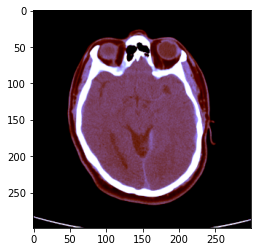

ID_004c4b503.png has a probability: 0.9760576 for a 'any' type of hemorrhage


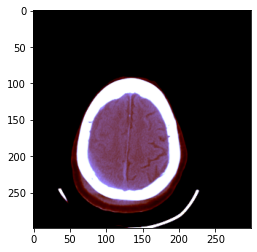

ID_004c4b503.png has a probability: 0.97629595 for a 'subdural' type of hemorrhage


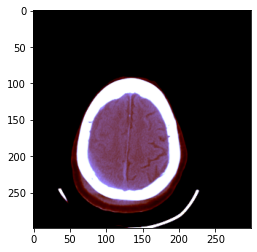

In [ ]:
from PIL import Image
for i in range(20): 
  
    for j in range(1,7): 
        if test_frame.iloc[i,j] > 0.8: 
            path = '/kaggle/tmp/' + str(test_frame.iloc[i,0])
            img = Image.open(path)
            plt.imshow(img)
            print(str(test_frame.iloc[i,0]) + " has a probability: "  + str(test_frame.iloc[i,j]) + " for a '" + str(test_frame.columns[j]) + "' type of hemorrhage")
            plt.show()

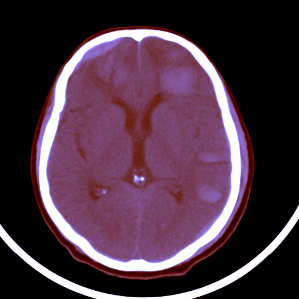

In [ ]:
#heatmap 
#The code used to show the heatmake was taken from: https://keras.io/examples/vision/grad_cam/
#Only slightly modified to fit this workflow and return the image with the highest predicition from the validtion set 
from IPython.display import Image, display

preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

img_path = '/kaggle/tmp/' + str(highest_predicted_img)
display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

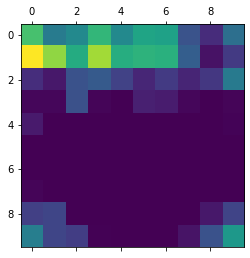

In [ ]:
img_size = (299, 299)

img_array = preprocess_input(get_img_array(img_path, size=img_size))

model.layers[-1].activation = None

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


In [ ]:
import matplotlib.cm as cm
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


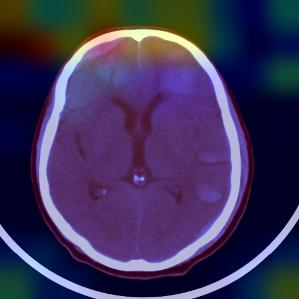

In [ ]:
save_and_display_gradcam(img_path, heatmap)